Using PCA followed by Logistic regression

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings from solvers that don't support certain penalties

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

class DataPreprocessor:
    def __init__(self, emoticons_path, deep_features_path, text_sequence_path):
        self.emoticons_path = emoticons_path
        self.deep_features_path = deep_features_path
        self.text_sequence_path = text_sequence_path
        self.label_encoder = LabelEncoder()
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000)

    def load_emoticons_data(self):
        emoticons_df = pd.read_csv(self.emoticons_path)
        encoded_emoticons = emoticons_df['input_emoticon'].apply(lambda x: list(self.label_encoder.fit_transform(list(x))))
        X_emoticons = pd.DataFrame(encoded_emoticons.tolist())
        y_emoticons = emoticons_df['label']
        return X_emoticons, y_emoticons

    def load_deep_features_data(self):
        deep_features = np.load(self.deep_features_path)
        X_deep = deep_features['features']
        X_deep_flattened = X_deep.reshape(X_deep.shape[0], -1)  # Flatten the 13x786 to 1x10218
        y_deep = deep_features['label']
        return X_deep_flattened, y_deep

    def load_text_sequence_data(self):
        text_sequence_df = pd.read_csv(self.text_sequence_path)
        X_text = self.vectorizer.fit_transform(text_sequence_df['input_str']).toarray()
        y_text = text_sequence_df['label']
        return X_text, y_text

    def combine_features(self, X_emoticons, X_deep_flattened, X_text):
        return np.concatenate([X_emoticons, X_deep_flattened, X_text], axis=1)

    def process(self):
        X_emoticons, y_emoticons = self.load_emoticons_data()
        X_deep_flattened, y_deep = self.load_deep_features_data()
        X_text, y_text = self.load_text_sequence_data()

        # Combine all features
        X_combined = self.combine_features(X_emoticons, X_deep_flattened, X_text)
        y_combined = y_emoticons  # Use emoticon labels or any consistent label
        return X_combined, y_combined

# Initialize the preprocessor
preprocessor = DataPreprocessor(
    emoticons_path='/content/train_emoticon.csv',
    deep_features_path='/content/train_feature.npz',
    text_sequence_path='/content/train_text_seq.csv'
)

# Process datasets
X_combined_train, y_combined_train = preprocessor.process()
print(X_combined_train.shape)

preprocessor_2 = DataPreprocessor(
    emoticons_path='/content/valid_emoticon.csv',
    deep_features_path='/content/valid_feature.npz',
    text_sequence_path='/content/valid_text_seq.csv'
)

# Process datasets
X_combined_test, y_combined_test = preprocessor_2.process()
print(X_combined_test.shape)
# Split into train and test sets


# List of PCA components to iterate over
pca_components = [200, 500, 1000]
training_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]

# Scaler
scaler = StandardScaler()
results=[]
for size in training_sizes:
    print(f"\nTraining with {int(size * 100)}% of the training data")

    if size < 1.0:
        # Split the data according to the specified training size
        X_train_subset, _, y_train_subset, _ = train_test_split(X_combined_train, y_combined_train, train_size=size, random_state=42)
    else:
        # Use the full training data
        X_train_subset, y_train_subset = X_combined_train, y_combined_train

    # Scale the data
    X_train_subset = scaler.fit_transform(X_train_subset)
    X_test_scaled = scaler.transform(X_combined_test)

    for n_components in pca_components:
        print(f"\nApplying PCA with {n_components} components")

        # Apply PCA on the training subset
        pca = PCA(n_components=n_components)
        X_train_subset_pca = pca.fit_transform(X_train_subset)
        print(f"Training shape after PCA: {X_train_subset_pca.shape}")

        X_test_pca = pca.transform(X_test_scaled)
        print(f"Test shape after PCA: {X_test_pca.shape}")

        # Set up the Logistic Regression model with GridSearchCV
        logistic_model = LogisticRegression(max_iter=1000)

        # Expand param_grid to include multiple solvers and penalties
        param_grid = {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs'],
            'penalty': ['l1', 'l2']

        }

        # Perform grid search
        grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

        # Train the model on the training subset
        grid_search.fit(X_train_subset_pca, y_train_subset)

        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Make predictions on the test set
        y_pred = best_model.predict(X_test_pca)

        # Evaluate the model
        accuracy = accuracy_score(y_combined_test, y_pred)
        report = classification_report(y_combined_test, y_pred)
        results.append({
                'PCA_components': n_components,
                'Dataset_size': size,
                'Accuracy': accuracy
            })
        print(f"Best Hyperparameters: {grid_search.best_params_}")
        print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
        print(f"Classification Report:\n{report}")


(7080, 10097)
(489, 10097)

Training with 20% of the training data

Applying PCA with 200 components
Training shape after PCA: (1416, 200)
Test shape after PCA: (489, 200)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Test Set Accuracy: 96.73%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       252
           1       0.95      0.98      0.97       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489


Applying PCA with 500 components
Training shape after PCA: (1416, 500)
Test shape after PCA: (489, 500)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Test Set Accuracy: 96.73%
Classification Report:
              precision    rec

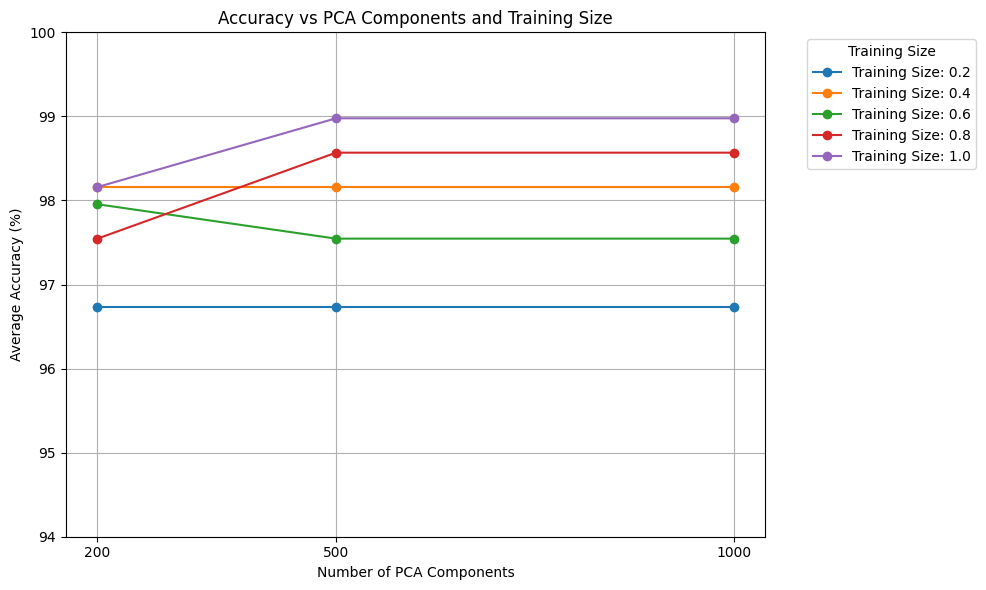

In [39]:

import matplotlib.pyplot as plt
import pandas as pd

def plot_accuracy_vs_pca_and_training_size(results):
    # Convert results to a DataFrame for easier plotting
    df = pd.DataFrame(results)

    # Pivot the DataFrame to have PCA components as rows and training sizes as columns
    pivot_df = df.pivot_table(index='PCA_components', columns='Dataset_size', values='Accuracy', aggfunc='mean')

    plt.figure(figsize=(10, 6))  # Adjust the size of the figure
    for size in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[size] * 100, marker='o', label=f'Training Size: {size:.1f}')

    plt.title('Accuracy vs PCA Components and Training Size')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Average Accuracy (%)')
    plt.xticks(pivot_df.index)  # Show PCA component values on x-axis
    plt.yticks(range(94, 101, 1))  # Set y-axis ticks from 90 to 100
    plt.ylim(94, 100)  # Set the y-axis limit to focus on the 90-100% range
    plt.legend(title='Training Size', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example usage:
plot_accuracy_vs_pca_and_training_size(results)


Logistic regression with SMOTE and PCA


Training with 20% of the training data

Applying PCA with 500 components
Training shape after PCA: (1426, 500)
Test shape after PCA: (489, 500)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Test Set Accuracy: 94.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       252
           1       0.93      0.95      0.94       237

    accuracy                           0.94       489
   macro avg       0.94      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489


Training with 40% of the training data

Applying PCA with 500 components
Training shape after PCA: (2888, 500)
Test shape after PCA: (489, 500)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test Set Accuracy: 96.73%
Classification Report:
              precisi

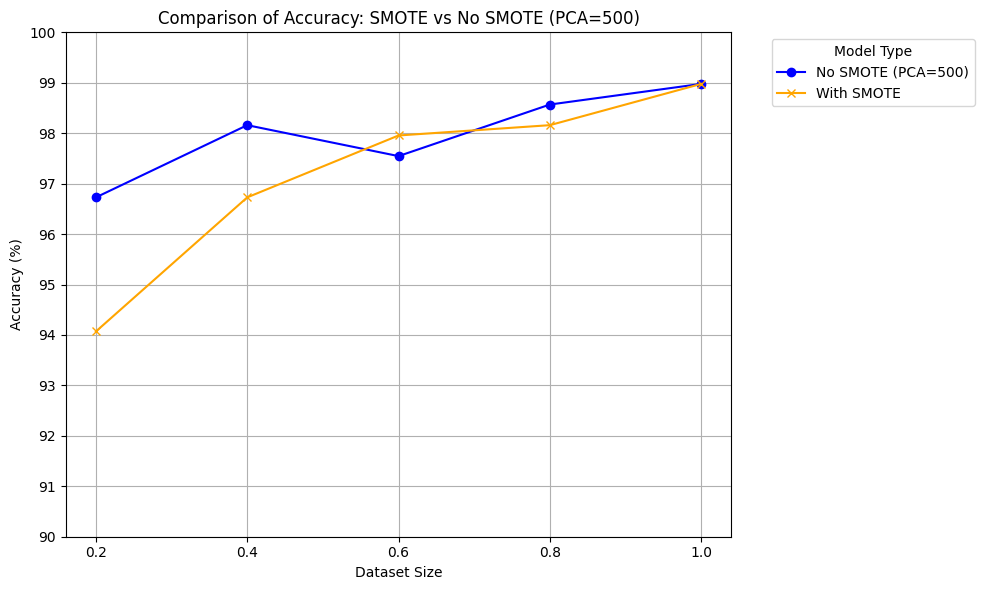

In [40]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define your training sizes
training_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]

# Initialize the scaler and SMOTE
scaler = StandardScaler()
smote = SMOTE(random_state=42)
results_smote=[]
for size in training_sizes:
    print(f"\nTraining with {int(size * 100)}% of the training data")

    if size < 1.0:
        # Split the data according to the specified training size
        X_train_subset, _, y_train_subset, _ = train_test_split(X_combined_train, y_combined_train, train_size=size, random_state=42)
    else:
        # Use the full training data
        X_train_subset, y_train_subset = X_combined_train, y_combined_train

    # Scale the training subset
    X_train_subset_scaled = scaler.fit_transform(X_train_subset)

    # Apply SMOTE to the scaled training subset
    X_train_subset_smote, y_train_subset_smote = smote.fit_resample(X_train_subset_scaled, y_train_subset)

    # Scale the test data using the same scaler fitted on training data
    X_test_scaled = scaler.transform(X_combined_test)
    print(f"\nApplying PCA with 500 components")

    pca = PCA(n_components=500)
    X_train_subset_pca = pca.fit_transform(X_train_subset_smote)
    print(f"Training shape after PCA: {X_train_subset_pca.shape}")

    X_test_pca = pca.transform(X_test_scaled)
    print(f"Test shape after PCA: {X_test_pca.shape}")

    # Set up the Logistic Regression model with GridSearchCV
    logistic_model = LogisticRegression(max_iter=1000)

    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['liblinear'],
        'penalty': ['l2'],  # Use l2 penalty
    }
    grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', verbose=1)

    # Train the model on the SMOTE balanced training subset
    grid_search.fit(X_train_subset_pca, y_train_subset_smote)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test_pca)

    # Evaluate the model
    accuracy = accuracy_score(y_combined_test, y_pred)
    report = classification_report(y_combined_test, y_pred)
    results_smote.append({
                'Dataset_size': size,
                'Accuracy': accuracy
            })
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
    print(f"Classification Report:\n{report}")


import matplotlib.pyplot as plt
import pandas as pd

def plot_comparison_smote_vs_no_smote(results, results_smote):
    # Convert results to DataFrames for easier manipulation
    df_no_smote = pd.DataFrame(results)
    df_smote = pd.DataFrame(results_smote)

    # Filter both DataFrames for PCA components equal to 500
    df_no_smote_filtered = df_no_smote[df_no_smote['PCA_components'] == 500]
    df_smote_filtered = df_smote[df_smote['Dataset_size'].isin(df_no_smote_filtered['Dataset_size'])]

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust the size of the figure

    # Plot No SMOTE results
    plt.plot(df_no_smote_filtered['Dataset_size'], df_no_smote_filtered['Accuracy'] * 100,
             marker='o', label='No SMOTE (PCA=500)', color='blue')

    # Plot SMOTE results
    plt.plot(df_smote_filtered['Dataset_size'], df_smote_filtered['Accuracy'] * 100,
             marker='x', label='With SMOTE', color='orange')

    plt.title('Comparison of Accuracy: SMOTE vs No SMOTE (PCA=500)')
    plt.xlabel('Dataset Size')
    plt.ylabel('Accuracy (%)')
    plt.xticks(df_no_smote_filtered['Dataset_size'])  # Show dataset size values on x-axis
    plt.yticks(range(90, 101, 1))  # Set y-axis ticks from 90 to 100
    plt.ylim(90, 100)  # Set the y-axis limit to focus on the 90-100% range
    plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example usage:
plot_comparison_smote_vs_no_smote(results, results_smote)


best model


In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings from solvers that don't support certain penalties

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

class DataPreprocessor:
    def __init__(self, emoticons_path, deep_features_path, text_sequence_path):
        self.emoticons_path = emoticons_path
        self.deep_features_path = deep_features_path
        self.text_sequence_path = text_sequence_path
        self.label_encoder = LabelEncoder()
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000)

    def load_emoticons_data(self):
        emoticons_df = pd.read_csv(self.emoticons_path)
        encoded_emoticons = emoticons_df['input_emoticon'].apply(lambda x: list(self.label_encoder.fit_transform(list(x))))
        X_emoticons = pd.DataFrame(encoded_emoticons.tolist())
        y_emoticons = emoticons_df['label']
        return X_emoticons, y_emoticons

    def load_deep_features_data(self):
        deep_features = np.load(self.deep_features_path)
        X_deep = deep_features['features']
        X_deep_flattened = X_deep.reshape(X_deep.shape[0], -1)  # Flatten the 13x786 to 1x10218
        y_deep = deep_features['label']
        return X_deep_flattened, y_deep

    def load_text_sequence_data(self):
        text_sequence_df = pd.read_csv(self.text_sequence_path)
        X_text = self.vectorizer.fit_transform(text_sequence_df['input_str']).toarray()
        y_text = text_sequence_df['label']
        return X_text, y_text

    def combine_features(self, X_emoticons, X_deep_flattened, X_text):
        return np.concatenate([X_emoticons, X_deep_flattened, X_text], axis=1)

    def process(self):
        X_emoticons, y_emoticons = self.load_emoticons_data()
        X_deep_flattened, y_deep = self.load_deep_features_data()
        X_text, y_text = self.load_text_sequence_data()

        # Combine all features
        X_combined = self.combine_features(X_emoticons, X_deep_flattened, X_text)
        y_combined = y_emoticons  # Use emoticon labels or any consistent label
        return X_combined, y_combined

# Initialize the preprocessor
preprocessor = DataPreprocessor(
    emoticons_path='/content/train_emoticon.csv',
    deep_features_path='/content/train_feature.npz',
    text_sequence_path='/content/train_text_seq.csv'
)

# Process datasets
X_combined_train, y_combined_train = preprocessor.process()

preprocessor_2 = DataPreprocessor(
    emoticons_path='/content/valid_emoticon.csv',
    deep_features_path='/content/valid_feature.npz',
    text_sequence_path='/content/valid_text_seq.csv'
)

# Process datasets
X_combined_test, y_combined_test = preprocessor_2.process()
# Split into train and test sets

# List of PCA components to iterate over
n_components = 1000

# Scaler
scaler = StandardScaler()
X_train_subset, y_train_subset = X_combined_train, y_combined_train

# Scale the data
X_train_subset = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_combined_test)

# Apply PCA on the training subset
pca = PCA(n_components=n_components)
X_train_subset_pca = pca.fit_transform(X_train_subset)
print(f"Training shape after PCA: {X_train_subset_pca.shape}")

X_test_pca = pca.transform(X_test_scaled)
print(f"Test shape after PCA: {X_test_pca.shape}")

# Set up the Logistic Regression model with GridSearchCV
logistic_model = LogisticRegression(max_iter=1000, C = 1, penalty='l1', solver = 'liblinear')

# Fit the model to the training data
logistic_model.fit(X_train_subset_pca, y_train_subset) # This line is added

# Make predictions on the test set
y_pred = logistic_model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_combined_test, y_pred)
report = classification_report(y_combined_test, y_pred)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
print(f"Classification Report:\n{report}")


Training shape after PCA: (7080, 1000)
Test shape after PCA: (489, 1000)
Test Set Accuracy: 98.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       252
           1       0.99      0.99      0.99       237

    accuracy                           0.99       489
   macro avg       0.99      0.99      0.99       489
weighted avg       0.99      0.99      0.99       489



using CNN of dataset 1 with PCA

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

class DataPreprocessor:
    def __init__(self, emoticons_path, deep_features_path, text_sequence_path):
        self.emoticons_path = emoticons_path
        self.deep_features_path = deep_features_path
        self.text_sequence_path = text_sequence_path
        self.label_encoder = LabelEncoder()
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000)

    def load_emoticons_data(self):
        emoticons_df = pd.read_csv(self.emoticons_path)
        encoded_emoticons = emoticons_df['input_emoticon'].apply(lambda x: list(self.label_encoder.fit_transform(list(x))))
        X_emoticons = pd.DataFrame(encoded_emoticons.tolist())
        y_emoticons = emoticons_df['label']
        return X_emoticons, y_emoticons

    def load_deep_features_data(self):
        deep_features = np.load(self.deep_features_path)
        X_deep = deep_features['features']
        X_deep_flattened = X_deep.reshape(X_deep.shape[0], -1)  # Flatten the 13x786 to 1x10218
        y_deep = deep_features['label']
        return X_deep_flattened, y_deep

    def load_text_sequence_data(self):
        text_sequence_df = pd.read_csv(self.text_sequence_path)
        X_text = self.vectorizer.fit_transform(text_sequence_df['input_str']).toarray()
        y_text = text_sequence_df['label']
        return X_text, y_text

    def combine_features(self, X_emoticons, X_deep_flattened, X_text):
        return np.concatenate([X_emoticons, X_deep_flattened, X_text], axis=1)

    def process(self):
        X_emoticons, y_emoticons = self.load_emoticons_data()
        X_deep_flattened, y_deep = self.load_deep_features_data()
        X_text, y_text = self.load_text_sequence_data()

        # Combine all features
        X_combined = self.combine_features(X_emoticons, X_deep_flattened, X_text)
        y_combined = y_emoticons  # Use emoticon labels or any consistent label
        return X_combined, y_combined

# Initialize the preprocessor
preprocessor = DataPreprocessor(
    emoticons_path='/content/train_emoticon.csv',
    deep_features_path='/content/train_feature.npz',
    text_sequence_path='/content/train_text_seq.csv'
)

# Process datasets
X_combined_train, y_combined_train = preprocessor.process()

preprocessor_2 = DataPreprocessor(
    emoticons_path='/content/valid_emoticon.csv',
    deep_features_path='/content/valid_feature.npz',
    text_sequence_path='/content/valid_text_seq.csv'
)

# Process test datasets
X_combined_test, y_combined_test = preprocessor_2.process()

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X_combined_train, y_combined_train, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_combined_test)

# Apply PCA on the scaled training data
n_components = 50  # Set desired number of PCA components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
print(f"Training shape after PCA: {X_train_pca.shape}")

# Apply PCA on the validation and test sets
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Reshaping data to work with Conv1D layers (3D format)
X_train_cnn = np.expand_dims(X_train_pca, axis=-1)
X_val_cnn = np.expand_dims(X_val_pca, axis=-1)
X_test_cnn = np.expand_dims(X_test_pca, axis=-1)

# Building the CNN model
model = Sequential([
    Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Conv1D(filters=8, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the CNN model
history = model.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_val_cnn, y_val), batch_size=16)

# Evaluating on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_combined_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

# Classification report
report = classification_report(y_combined_test, y_pred_cnn)
print(f"Classification Report:\n{report}")
print(model.summary())

Training shape after PCA: (5664, 50)
Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6845 - loss: 0.5654 - val_accuracy: 0.9442 - val_loss: 0.1769
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9505 - loss: 0.1367 - val_accuracy: 0.9619 - val_loss: 0.1030
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9724 - loss: 0.0810 - val_accuracy: 0.9753 - val_loss: 0.0747
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9691 - loss: 0.0711 - val_accuracy: 0.9781 - val_loss: 0.0606
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9774 - loss: 0.0599 - val_accuracy: 0.9753 - val_loss: 0.0574
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9840 - loss: 0.0449 - val_accuracy: 0.9767 - val_loss: 0.0539
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9784 - loss: 0.0519 - val_accuracy: 0.9781 - val_loss: 0.0495
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 48, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 46, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 368)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805 (7.05 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204 (4.71 KB)

None


Random forest after PCA

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

class DataPreprocessor:
    def __init__(self, emoticons_path, deep_features_path, text_sequence_path):
        self.emoticons_path = emoticons_path
        self.deep_features_path = deep_features_path
        self.text_sequence_path = text_sequence_path
        self.label_encoder = LabelEncoder()
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000)

    def load_emoticons_data(self):
        emoticons_df = pd.read_csv(self.emoticons_path)
        encoded_emoticons = emoticons_df['input_emoticon'].apply(lambda x: list(self.label_encoder.fit_transform(list(x))))
        X_emoticons = pd.DataFrame(encoded_emoticons.tolist())
        y_emoticons = emoticons_df['label']
        return X_emoticons, y_emoticons

    def load_deep_features_data(self):
        deep_features = np.load(self.deep_features_path)
        X_deep = deep_features['features']
        X_deep_flattened = X_deep.reshape(X_deep.shape[0], -1)  # Flatten the 13x786 to 1x10218
        y_deep = deep_features['label']
        return X_deep_flattened, y_deep

    def load_text_sequence_data(self):
        text_sequence_df = pd.read_csv(self.text_sequence_path)
        X_text = self.vectorizer.fit_transform(text_sequence_df['input_str']).toarray()
        y_text = text_sequence_df['label']
        return X_text, y_text

    def combine_features(self, X_emoticons, X_deep_flattened, X_text):
        return np.concatenate([X_emoticons, X_deep_flattened, X_text], axis=1)

    def process(self):
        X_emoticons, y_emoticons = self.load_emoticons_data()
        X_deep_flattened, y_deep = self.load_deep_features_data()
        X_text, y_text = self.load_text_sequence_data()

        # Combine all features
        X_combined = self.combine_features(X_emoticons, X_deep_flattened, X_text)
        y_combined = y_emoticons  # Use emoticon labels or any consistent label
        return X_combined, y_combined

# Initialize the preprocessor
preprocessor = DataPreprocessor(
    emoticons_path='/content/train_emoticon.csv',
    deep_features_path='/content/train_feature.npz',
    text_sequence_path='/content/train_text_seq.csv'
)

# Process datasets
X_combined_train, y_combined_train = preprocessor.process()

preprocessor_2 = DataPreprocessor(
    emoticons_path='/content/valid_emoticon.csv',
    deep_features_path='/content/valid_feature.npz',
    text_sequence_path='/content/valid_text_seq.csv'
)

# Process test datasets
X_combined_test, y_combined_test = preprocessor_2.process()

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X_combined_train, y_combined_train, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_combined_test)

# Apply PCA on the scaled training data
n_components = 50  # Set desired number of PCA components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
print(f"Training shape after PCA: {X_train_pca.shape}")

# Apply PCA on the validation and test sets
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Build the RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_pca, y_train)

# Predict on validation data
y_val_pred = rf_model.predict(X_val_pca)

# Evaluate the model on validation data
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Predict on the test set
y_test_pred = rf_model.predict(X_test_pca)

# Evaluate on the test set
test_accuracy = accuracy_score(y_combined_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Test Classification Report:")
print(classification_report(y_combined_test, y_test_pred))


Training shape after PCA: (5664, 50)
Validation Accuracy: 98.02%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       719
           1       0.99      0.97      0.98       697

    accuracy                           0.98      1416
   macro avg       0.98      0.98      0.98      1416
weighted avg       0.98      0.98      0.98      1416

Test Accuracy: 97.75%
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       252
           1       0.98      0.97      0.98       237

    accuracy                           0.98       489
   macro avg       0.98      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



Comparing accuracies of the above models

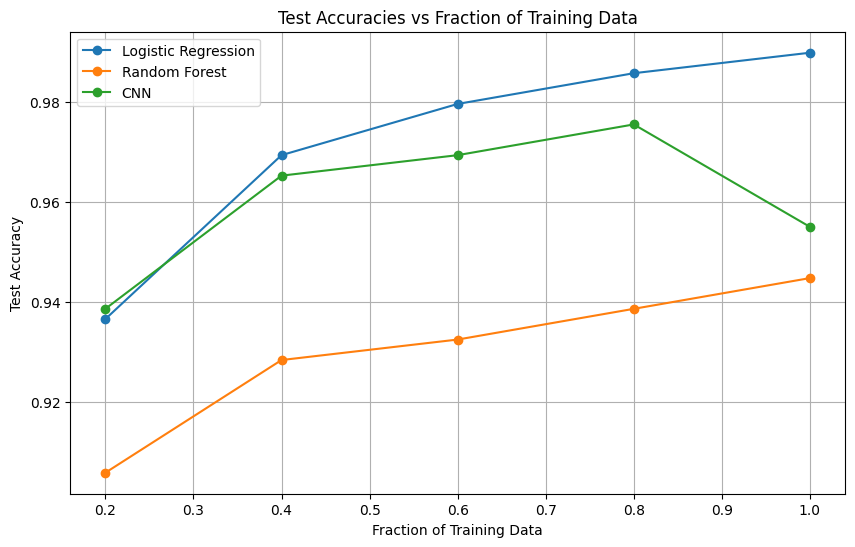

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Fraction of training data
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]

# Function to evaluate test accuracy for Logistic Regression
def train_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Function to evaluate test accuracy for RandomForest
def train_random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Function to evaluate test accuracy for CNN
def train_cnn(X_train, y_train, X_test, y_test, sequence_length):
    model = Sequential([
        Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
        Conv1D(filters=8, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Reshape data to 3D for Conv1D
    X_train_cnn = np.expand_dims(X_train, axis=-1)
    X_test_cnn = np.expand_dims(X_test, axis=-1)

    # Train the CNN model
    model.fit(X_train_cnn, y_train, epochs=5, batch_size=16, verbose=0)

    # Evaluate the model on test set
    test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
    return test_accuracy

# Store test accuracies for each model
test_accuracies_logistic = []
test_accuracies_rf = []
test_accuracies_cnn = []

# Preprocess data (Assuming you have preprocessed the data)
X_combined_train, y_combined_train = preprocessor.process()  # Train data
X_combined_test, y_combined_test = preprocessor_2.process()  # Test data

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_combined_train)
X_test_scaled = scaler.transform(X_combined_test)

# Apply PCA on scaled data
n_components = 1000
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# For CNN, reshape the PCA-transformed data for Conv1D input
sequence_length = X_train_pca.shape[1]

# Loop through different training fractions
for fraction in fractions:
    # Split the data according to the fraction
    if fraction == 1.0:
        X_train_subset, y_train_subset = X_train_pca, y_combined_train
    else:
        X_train_subset, _, y_train_subset, _ = train_test_split(X_train_pca, y_combined_train, train_size=fraction, random_state=42)

    # Train Logistic Regression and record test accuracy
    accuracy_logistic = train_logistic_regression(X_train_subset, y_train_subset, X_test_pca, y_combined_test)
    test_accuracies_logistic.append(accuracy_logistic)

    # Train Random Forest and record test accuracy
    accuracy_rf = train_random_forest(X_train_subset, y_train_subset, X_test_pca, y_combined_test)
    test_accuracies_rf.append(accuracy_rf)

    # Train CNN and record test accuracy
    accuracy_cnn = train_cnn(X_train_subset, y_train_subset, X_test_pca, y_combined_test, sequence_length)
    test_accuracies_cnn.append(accuracy_cnn)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(fractions, test_accuracies_logistic, label='Logistic Regression', marker='o')
plt.plot(fractions, test_accuracies_rf, label='Random Forest', marker='o')
plt.plot(fractions, test_accuracies_cnn, label='CNN', marker='o')
plt.title('Test Accuracies vs Fraction of Training Data')
plt.xlabel('Fraction of Training Data')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Finding best pca size for CNNs taking into consideration the average accuracy obtained.


Training with 20% of the training data

Applying PCA with 20 components
Training shape after PCA: (1416, 20)
Test shape after PCA: (489, 20)
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5894 - loss: 0.8808 - val_accuracy: 0.6761 - val_loss: 0.5871
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7746 - loss: 0.5074 - val_accuracy: 0.7500 - val_loss: 0.4810
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.3918 - val_accuracy: 0.7958 - val_loss: 0.3927
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8932 - loss: 0.2958 - val_accuracy: 0.8627 - val_loss: 0.3140
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9129 - loss: 0.2567 - val_accuracy: 0.8873 - val_loss: 0.2735
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9047 - loss: 0.2264 - val_accuracy: 0.9085 - val_loss: 0.2352
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9241 - loss: 0.2013 - val_accuracy: 0.

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_68 (Conv1D)                   │ (None, 18, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_69 (Conv1D)                   │ (None, 16, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_34 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085 (4.24 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 724 (2.83 KB)

None

Applying PCA with 50 components
Training shape after PCA: (1416, 50)
Test shape after PCA: (489, 50)
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5382 - loss: 0.8368 - val_accuracy: 0.6056 - val_loss: 0.6691
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6418 - loss: 0.6306 - val_accuracy: 0.7148 - val_loss: 0.5580
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7800 - loss: 0.4879 - val_accuracy: 0.8099 - val_loss: 0.4267
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8798 - loss: 0.3527 - val_accuracy: 0.8697 - val_loss: 0.3099
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9396 - loss: 0.2335 - val_accuracy: 0.9085 - val_loss: 0.2283
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9566 - loss: 0.1671 - val_accuracy: 0.9190 - val_loss: 0.1897
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9712 - loss: 0.1263 - val_accuracy: 0.9261 - val_loss: 0.1675
Epoch 8/10


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_70 (Conv1D)                   │ (None, 48, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 46, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 368)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805 (7.05 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204 (4.71 KB)

None

Applying PCA with 200 components
Training shape after PCA: (1416, 200)
Test shape after PCA: (489, 200)
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5225 - loss: 0.7148 - val_accuracy: 0.5493 - val_loss: 0.6617
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7422 - loss: 0.5460 - val_accuracy: 0.7430 - val_loss: 0.5379
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8777 - loss: 0.3840 - val_accuracy: 0.7324 - val_loss: 0.4801
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9322 - loss: 0.2505 - val_accuracy: 0.8627 - val_loss: 0.3363
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9609 - loss: 0.1626 - val_accuracy: 0.8627 - val_loss: 0.2862
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9701 - loss: 0.1192 - val_accuracy: 0.9190 - val_loss: 0.2160
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.0782 - val_accuracy: 0.9225 - val_loss: 0.2027
Epoch 8/

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)                   │ (None, 198, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_73 (Conv1D)                   │ (None, 196, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │           1,569 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,405 (21.12 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,604 (14.08 KB)

None

Applying PCA with 500 components
Training shape after PCA: (1416, 500)
Test shape after PCA: (489, 500)
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5341 - loss: 0.7023 - val_accuracy: 0.6303 - val_loss: 0.6396
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7119 - loss: 0.5875 - val_accuracy: 0.7359 - val_loss: 0.5278
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8619 - loss: 0.3868 - val_accuracy: 0.8099 - val_loss: 0.4090
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9548 - loss: 0.2230 - val_accuracy: 0.8662 - val_loss: 0.3182
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9872 - loss: 0.1338 - val_accuracy: 0.8380 - val_loss: 0.2986
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9974 - loss: 0.0795 - val_accuracy: 0.8592 - val_loss: 0.2678
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9982 - loss: 0.0531 - val_accuracy: 0.8838 - val_loss: 0.2350
Epoch 8/

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_74 (Conv1D)                   │ (None, 498, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_75 (Conv1D)                   │ (None, 496, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │           3,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,605 (49.24 KB)

 Trainable params: 4,201 (16.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,404 (32.83 KB)

None

Applying PCA with 1000 components
Training shape after PCA: (1416, 1000)
Test shape after PCA: (489, 1000)
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5505 - loss: 0.6992 - val_accuracy: 0.7430 - val_loss: 0.6095
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8163 - loss: 0.5154 - val_accuracy: 0.7430 - val_loss: 0.4553
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9172 - loss: 0.2887 - val_accuracy: 0.8944 - val_loss: 0.2822
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9804 - loss: 0.1388 - val_accuracy: 0.9261 - val_loss: 0.1996
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9958 - loss: 0.0782 - val_accuracy: 0.9049 - val_loss: 0.2068
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9968 - loss: 0.0479 - val_accuracy: 0.9120 - val_loss: 0.1763
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9971 - loss: 0.0374 - val_accuracy: 0.9085 - val_loss: 0.1858

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_76 (Conv1D)                   │ (None, 998, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_77 (Conv1D)                   │ (None, 996, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_38 (Flatten)                 │ (None, 7968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1)                   │           7,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,605 (96.12 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,404 (64.08 KB)

None

Training with 40% of the training data

Applying PCA with 20 components
Training shape after PCA: (2832, 20)
Test shape after PCA: (489, 20)
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6559 - loss: 0.6569 - val_accuracy: 0.8959 - val_loss: 0.3135
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8932 - loss: 0.2787 - val_accuracy: 0.9436 - val_loss: 0.1698
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9446 - loss: 0.1542 - val_accuracy: 0.9471 - val_loss: 0.1331
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9577 - loss: 0.1186 - val_accuracy: 0.9506 - val_loss: 0.1166
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9673 - loss: 0.0924 - val_accuracy: 0.9471 - val_loss: 0.1150
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9691 - loss: 0.0947 - val_accuracy: 0.9506 - val_loss: 0.0994
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9754 - loss: 0.0780

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)                   │ (None, 18, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_79 (Conv1D)                   │ (None, 16, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_39 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085 (4.24 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 724 (2.83 KB)

None

Applying PCA with 50 components
Training shape after PCA: (2832, 50)
Test shape after PCA: (489, 50)
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5461 - loss: 0.7717 - val_accuracy: 0.7813 - val_loss: 0.4829
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8463 - loss: 0.4115 - val_accuracy: 0.9171 - val_loss: 0.2137
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9414 - loss: 0.1772 - val_accuracy: 0.9559 - val_loss: 0.1321
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9622 - loss: 0.1202 - val_accuracy: 0.9453 - val_loss: 0.1157
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9676 - loss: 0.0883 - val_accuracy: 0.9559 - val_loss: 0.0948
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9730 - loss: 0.0728 - val_accuracy: 0.9594 - val_loss: 0.1011
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9743 - loss: 0.0682 - val_accuracy: 0.9647 - val_loss: 0.07

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_80 (Conv1D)                   │ (None, 48, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_81 (Conv1D)                   │ (None, 46, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_40 (Flatten)                 │ (None, 368)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │             369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805 (7.05 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204 (4.71 KB)

None

Applying PCA with 200 components
Training shape after PCA: (2832, 200)
Test shape after PCA: (489, 200)
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6354 - loss: 0.6363 - val_accuracy: 0.8660 - val_loss: 0.3670
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9049 - loss: 0.2994 - val_accuracy: 0.9171 - val_loss: 0.2030
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9679 - loss: 0.1376 - val_accuracy: 0.9242 - val_loss: 0.1561
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9749 - loss: 0.0890 - val_accuracy: 0.9453 - val_loss: 0.1277
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9840 - loss: 0.0626 - val_accuracy: 0.9506 - val_loss: 0.1217
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9910 - loss: 0.0477 - val_accuracy: 0.9524 - val_loss: 0.1131
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9951 - loss: 0.0334 - val_accuracy: 0.9418 - val_loss: 0

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_82 (Conv1D)                   │ (None, 198, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_83 (Conv1D)                   │ (None, 196, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_41 (Flatten)                 │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │           1,569 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,405 (21.12 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,604 (14.08 KB)

None

Applying PCA with 500 components
Training shape after PCA: (2832, 500)
Test shape after PCA: (489, 500)
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5779 - loss: 0.6649 - val_accuracy: 0.8272 - val_loss: 0.4269
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9058 - loss: 0.3023 - val_accuracy: 0.9259 - val_loss: 0.1949
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9680 - loss: 0.1242 - val_accuracy: 0.9347 - val_loss: 0.1541
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9829 - loss: 0.0711 - val_accuracy: 0.9489 - val_loss: 0.1396
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9934 - loss: 0.0441 - val_accuracy: 0.9453 - val_loss: 0.1310
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9973 - loss: 0.0301 - val_accuracy: 0.9453 - val_loss: 0.1300
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9976 - loss: 0.0212 - val_accuracy: 0.9383 - val_loss: 

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)                   │ (None, 498, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_85 (Conv1D)                   │ (None, 496, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_42 (Flatten)                 │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │           3,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,605 (49.24 KB)

 Trainable params: 4,201 (16.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,404 (32.83 KB)

None

Applying PCA with 1000 components
Training shape after PCA: (2832, 1000)
Test shape after PCA: (489, 1000)
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6133 - loss: 0.6356 - val_accuracy: 0.8871 - val_loss: 0.3126
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9435 - loss: 0.2230 - val_accuracy: 0.9189 - val_loss: 0.1767
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9713 - loss: 0.1011 - val_accuracy: 0.9400 - val_loss: 0.1420
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9891 - loss: 0.0641 - val_accuracy: 0.9206 - val_loss: 0.1708
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9877 - loss: 0.0498 - val_accuracy: 0.9471 - val_loss: 0.1292
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9943 - loss: 0.0282 - val_accuracy: 0.9436 - val_loss: 0.1348
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9976 - loss: 0.0223 - val_accuracy: 0.9453 - val_l

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_86 (Conv1D)                   │ (None, 998, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_87 (Conv1D)                   │ (None, 996, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_43 (Flatten)                 │ (None, 7968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │           7,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,605 (96.12 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,404 (64.08 KB)

None

Training with 60% of the training data

Applying PCA with 20 components
Training shape after PCA: (4248, 20)
Test shape after PCA: (489, 20)
Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6540 - loss: 0.6754 - val_accuracy: 0.9012 - val_loss: 0.2519
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9314 - loss: 0.1945 - val_accuracy: 0.9294 - val_loss: 0.1511
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9466 - loss: 0.1315 - val_accuracy: 0.9447 - val_loss: 0.1252
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9489 - loss: 0.1076 - val_accuracy: 0.9553 - val_loss: 0.1130
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9694 - loss: 0.0858 - val_accuracy: 0.9565 - val_loss: 0.1039
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9612 - loss: 0.0856 - val_accuracy: 0.9588 - val_loss: 0.1002
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9681 - loss: 0.0812

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_88 (Conv1D)                   │ (None, 18, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_89 (Conv1D)                   │ (None, 16, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_44 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085 (4.24 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 724 (2.83 KB)

None

Applying PCA with 50 components
Training shape after PCA: (4248, 50)
Test shape after PCA: (489, 50)
Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6128 - loss: 0.7079 - val_accuracy: 0.8953 - val_loss: 0.2808
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9116 - loss: 0.2372 - val_accuracy: 0.9506 - val_loss: 0.1339
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9565 - loss: 0.1228 - val_accuracy: 0.9612 - val_loss: 0.0995
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9667 - loss: 0.0917 - val_accuracy: 0.9671 - val_loss: 0.0836
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0715 - val_accuracy: 0.9776 - val_loss: 0.0674
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9788 - loss: 0.0585 - val_accuracy: 0.9741 - val_loss: 0.0612
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9727 - loss: 0.0618 - val_accuracy: 0.9812 - val_loss: 0.05

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_90 (Conv1D)                   │ (None, 48, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_91 (Conv1D)                   │ (None, 46, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_45 (Flatten)                 │ (None, 368)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1)                   │             369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805 (7.05 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204 (4.71 KB)

None

Applying PCA with 200 components
Training shape after PCA: (4248, 200)
Test shape after PCA: (489, 200)
Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5800 - loss: 0.6911 - val_accuracy: 0.8635 - val_loss: 0.3432
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8964 - loss: 0.2765 - val_accuracy: 0.9282 - val_loss: 0.1857
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9557 - loss: 0.1324 - val_accuracy: 0.9000 - val_loss: 0.1957
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9653 - loss: 0.0963 - val_accuracy: 0.9400 - val_loss: 0.1259
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9817 - loss: 0.0615 - val_accuracy: 0.9576 - val_loss: 0.0991
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9866 - loss: 0.0465 - val_accuracy: 0.9588 - val_loss: 0.0872
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0409 - val_accuracy: 0.9588 - val_loss: 0

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_92 (Conv1D)                   │ (None, 198, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_93 (Conv1D)                   │ (None, 196, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_46 (Flatten)                 │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │           1,569 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,405 (21.12 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,604 (14.08 KB)

None

Applying PCA with 500 components
Training shape after PCA: (4248, 500)
Test shape after PCA: (489, 500)
Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6154 - loss: 0.6437 - val_accuracy: 0.8518 - val_loss: 0.3535
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9202 - loss: 0.2350 - val_accuracy: 0.9447 - val_loss: 0.1449
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9766 - loss: 0.0896 - val_accuracy: 0.9541 - val_loss: 0.1079
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9886 - loss: 0.0551 - val_accuracy: 0.9529 - val_loss: 0.1002
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9910 - loss: 0.0397 - val_accuracy: 0.9447 - val_loss: 0.1224
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9970 - loss: 0.0244 - val_accuracy: 0.9494 - val_loss: 0.1068
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9971 - loss: 0.0206 - val_accuracy: 0.9624 - val_loss: 

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_94 (Conv1D)                   │ (None, 498, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_95 (Conv1D)                   │ (None, 496, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_47 (Flatten)                 │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │           3,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,605 (49.24 KB)

 Trainable params: 4,201 (16.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,404 (32.83 KB)

None

Applying PCA with 1000 components
Training shape after PCA: (4248, 1000)
Test shape after PCA: (489, 1000)
Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6884 - loss: 0.5725 - val_accuracy: 0.9376 - val_loss: 0.2017
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9515 - loss: 0.1481 - val_accuracy: 0.9529 - val_loss: 0.1119
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9803 - loss: 0.0716 - val_accuracy: 0.9494 - val_loss: 0.1158
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9907 - loss: 0.0440 - val_accuracy: 0.9553 - val_loss: 0.1024
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9971 - loss: 0.0252 - val_accuracy: 0.9565 - val_loss: 0.1002
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9957 - loss: 0.0220 - val_accuracy: 0.9553 - val_loss: 0.1070
Epoch 7/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9991 - loss: 0.0116 - val_accuracy: 0.9553 - val_l

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_96 (Conv1D)                   │ (None, 998, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_97 (Conv1D)                   │ (None, 996, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_48 (Flatten)                 │ (None, 7968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │           7,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,605 (96.12 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,404 (64.08 KB)

None

Training with 80% of the training data

Applying PCA with 20 components
Training shape after PCA: (5664, 20)
Test shape after PCA: (489, 20)
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6282 - loss: 0.6812 - val_accuracy: 0.9100 - val_loss: 0.2147
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9257 - loss: 0.1764 - val_accuracy: 0.9417 - val_loss: 0.1345
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9514 - loss: 0.1162 - val_accuracy: 0.9506 - val_loss: 0.1133
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9639 - loss: 0.0930 - val_accuracy: 0.9568 - val_loss: 0.0994
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9672 - loss: 0.0817 - val_accuracy: 0.9594 - val_loss: 0.0902
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9649 - loss: 0.0787 - val_accuracy: 0.9629 - val_loss: 0.0825
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9693 - loss: 0.0811

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_98 (Conv1D)                   │ (None, 18, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_99 (Conv1D)                   │ (None, 16, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_49 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085 (4.24 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 724 (2.83 KB)

None

Applying PCA with 50 components
Training shape after PCA: (5664, 50)
Test shape after PCA: (489, 50)
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6563 - loss: 0.6280 - val_accuracy: 0.9276 - val_loss: 0.2050
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9401 - loss: 0.1691 - val_accuracy: 0.9568 - val_loss: 0.1166
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9633 - loss: 0.1037 - val_accuracy: 0.9638 - val_loss: 0.0910
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9677 - loss: 0.0867 - val_accuracy: 0.9726 - val_loss: 0.0805
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 0.0664 - val_accuracy: 0.9726 - val_loss: 0.0751
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9747 - loss: 0.0656 - val_accuracy: 0.9709 - val_loss: 0.0692
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.0691 - val_accuracy: 0.9753 - val_loss: 0.06

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_100 (Conv1D)                  │ (None, 48, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_101 (Conv1D)                  │ (None, 46, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_50 (Flatten)                 │ (None, 368)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │             369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805 (7.05 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204 (4.71 KB)

None

Applying PCA with 200 components
Training shape after PCA: (5664, 200)
Test shape after PCA: (489, 200)
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6863 - loss: 0.5741 - val_accuracy: 0.9444 - val_loss: 0.1802
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9490 - loss: 0.1486 - val_accuracy: 0.9629 - val_loss: 0.1089
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9681 - loss: 0.0877 - val_accuracy: 0.9647 - val_loss: 0.0920
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9815 - loss: 0.0568 - val_accuracy: 0.9700 - val_loss: 0.0854
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9886 - loss: 0.0412 - val_accuracy: 0.9647 - val_loss: 0.0898
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9863 - loss: 0.0422 - val_accuracy: 0.9718 - val_loss: 0.0830
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9909 - loss: 0.0287 - val_accuracy: 0.9444 - val_loss: 0

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_102 (Conv1D)                  │ (None, 198, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_103 (Conv1D)                  │ (None, 196, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_51 (Flatten)                 │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │           1,569 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,405 (21.12 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,604 (14.08 KB)

None

Applying PCA with 500 components
Training shape after PCA: (5664, 500)
Test shape after PCA: (489, 500)
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7107 - loss: 0.5574 - val_accuracy: 0.9135 - val_loss: 0.2100
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9239 - loss: 0.1781 - val_accuracy: 0.9594 - val_loss: 0.1148
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9701 - loss: 0.0879 - val_accuracy: 0.9488 - val_loss: 0.1236
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9837 - loss: 0.0576 - val_accuracy: 0.9523 - val_loss: 0.1143
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9861 - loss: 0.0427 - val_accuracy: 0.9541 - val_loss: 0.0988
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9949 - loss: 0.0305 - val_accuracy: 0.9532 - val_loss: 0.0970
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9948 - loss: 0.0244 - val_accuracy: 0.9515 - val_loss: 0

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_104 (Conv1D)                  │ (None, 498, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_105 (Conv1D)                  │ (None, 496, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_52 (Flatten)                 │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │           3,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,605 (49.24 KB)

 Trainable params: 4,201 (16.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,404 (32.83 KB)

None

Applying PCA with 1000 components
Training shape after PCA: (5664, 1000)
Test shape after PCA: (489, 1000)
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6947 - loss: 0.5543 - val_accuracy: 0.9338 - val_loss: 0.1792
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9547 - loss: 0.1298 - val_accuracy: 0.9506 - val_loss: 0.1172
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9802 - loss: 0.0656 - val_accuracy: 0.9559 - val_loss: 0.1060
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9909 - loss: 0.0421 - val_accuracy: 0.9629 - val_loss: 0.0853
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.9665 - val_loss: 0.0761
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9962 - loss: 0.0215 - val_accuracy: 0.9682 - val_loss: 0.0892
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9955 - loss: 0.0172 - val_accuracy: 0.9656 - val_l

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_106 (Conv1D)                  │ (None, 998, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_107 (Conv1D)                  │ (None, 996, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_53 (Flatten)                 │ (None, 7968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │           7,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,605 (96.12 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,404 (64.08 KB)

None

Training with 100% of the training data

Applying PCA with 20 components
Training shape after PCA: (7080, 20)
Test shape after PCA: (489, 20)
Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8122 - loss: 0.4095 - val_accuracy: 0.9371 - val_loss: 0.1480
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9502 - loss: 0.1229 - val_accuracy: 0.9576 - val_loss: 0.1044
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9615 - loss: 0.0950 - val_accuracy: 0.9626 - val_loss: 0.0889
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9667 - loss: 0.0791 - val_accuracy: 0.9710 - val_loss: 0.0815
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9683 - loss: 0.0734 - val_accuracy: 0.9696 - val_loss: 0.0709
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.0657 - val_accuracy: 0.9725 - val_loss: 0.0656
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9722 - loss: 0.063

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_108 (Conv1D)                  │ (None, 18, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_109 (Conv1D)                  │ (None, 16, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_54 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085 (4.24 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 724 (2.83 KB)

None

Applying PCA with 50 components
Training shape after PCA: (7080, 50)
Test shape after PCA: (489, 50)
Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6602 - loss: 0.6247 - val_accuracy: 0.9258 - val_loss: 0.1892
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9472 - loss: 0.1394 - val_accuracy: 0.9590 - val_loss: 0.1022
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9689 - loss: 0.0830 - val_accuracy: 0.9710 - val_loss: 0.0768
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9768 - loss: 0.0617 - val_accuracy: 0.9746 - val_loss: 0.0686
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9770 - loss: 0.0581 - val_accuracy: 0.9732 - val_loss: 0.0688
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9800 - loss: 0.0538 - val_accuracy: 0.9675 - val_loss: 0.0776
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9820 - loss: 0.0494 - val_accuracy: 0.9781 - val_loss: 0.05

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_110 (Conv1D)                  │ (None, 48, 8)               │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_111 (Conv1D)                  │ (None, 46, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_55 (Flatten)                 │ (None, 368)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1)                   │             369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805 (7.05 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204 (4.71 KB)

None

Applying PCA with 200 components
Training shape after PCA: (7080, 200)
Test shape after PCA: (489, 200)
Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7019 - loss: 0.5570 - val_accuracy: 0.9343 - val_loss: 0.1654
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9517 - loss: 0.1228 - val_accuracy: 0.9470 - val_loss: 0.1227
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9750 - loss: 0.0677 - val_accuracy: 0.9668 - val_loss: 0.0799
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9827 - loss: 0.0498 - val_accuracy: 0.9541 - val_loss: 0.1067
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9854 - loss: 0.0460 - val_accuracy: 0.9633 - val_loss: 0.0831
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9852 - loss: 0.0385 - val_accuracy: 0.9668 - val_loss: 0.0718
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9914 - loss: 0.0299 - val_accuracy: 0.9718 - val_loss: 0

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_112 (Conv1D)                  │ (None, 198, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_113 (Conv1D)                  │ (None, 196, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_56 (Flatten)                 │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1)                   │           1,569 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,405 (21.12 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,604 (14.08 KB)

None

Applying PCA with 500 components
Training shape after PCA: (7080, 500)
Test shape after PCA: (489, 500)
Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6877 - loss: 0.5533 - val_accuracy: 0.9273 - val_loss: 0.1689
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9680 - loss: 0.1060 - val_accuracy: 0.9612 - val_loss: 0.0883
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9839 - loss: 0.0517 - val_accuracy: 0.9605 - val_loss: 0.0863
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9849 - loss: 0.0422 - val_accuracy: 0.9703 - val_loss: 0.0744
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9961 - loss: 0.0220 - val_accuracy: 0.9612 - val_loss: 0.1042
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9927 - loss: 0.0219 - val_accuracy: 0.9746 - val_loss: 0.0576
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9988 - loss: 0.0105 - val_accuracy: 0.9781 - val_loss: 

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_114 (Conv1D)                  │ (None, 498, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_115 (Conv1D)                  │ (None, 496, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_57 (Flatten)                 │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1)                   │           3,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,605 (49.24 KB)

 Trainable params: 4,201 (16.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,404 (32.83 KB)

None

Applying PCA with 1000 components
Training shape after PCA: (7080, 1000)
Test shape after PCA: (489, 1000)
Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7380 - loss: 0.4941 - val_accuracy: 0.9223 - val_loss: 0.1721
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9680 - loss: 0.0887 - val_accuracy: 0.9463 - val_loss: 0.1089
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9777 - loss: 0.0628 - val_accuracy: 0.9682 - val_loss: 0.0734
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9867 - loss: 0.0377 - val_accuracy: 0.9619 - val_loss: 0.1017
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9890 - loss: 0.0288 - val_accuracy: 0.9739 - val_loss: 0.0672
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9944 - loss: 0.0199 - val_accuracy: 0.9675 - val_loss: 0.0671
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9983 - loss: 0.0119 - val_accuracy: 0.9675 - val_lo

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_116 (Conv1D)                  │ (None, 998, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_117 (Conv1D)                  │ (None, 996, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_58 (Flatten)                 │ (None, 7968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1)                   │           7,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,605 (96.12 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,404 (64.08 KB)

None
Best PCA Component: 1000.0, with highest Average Accuracy: 96.56%


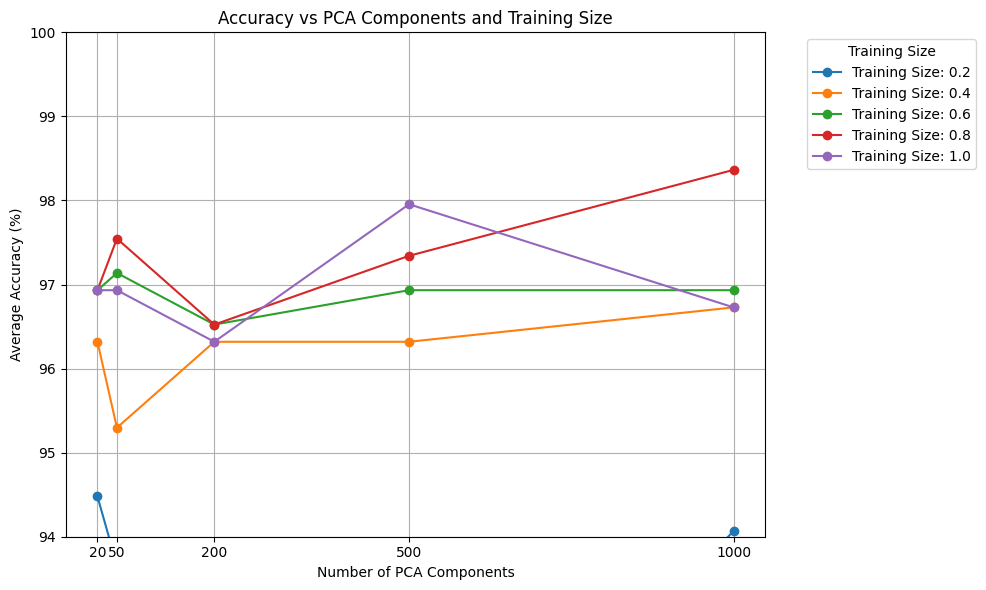

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

# Define training sizes and PCA components to loop through
training_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]  # 20%, 40%, 60%, 80%, 100% of data
pca_components = [20, 50, 200, 500, 1000]         # Different PCA component sizes

# Placeholder for results
results_cnn = []

# Initialize the scaler
scaler = StandardScaler()

for size in training_sizes:
    print(f"\nTraining with {int(size * 100)}% of the training data")

    if size < 1.0:
        # Split the data according to the specified training size
        X_train_subset, _, y_train_subset, _ = train_test_split(X_combined_train, y_combined_train, train_size=size, random_state=42)
    else:
        # Use the full training data
        X_train_subset, y_train_subset = X_combined_train, y_combined_train

    # Scale the training subset data
    X_train_subset_scaled = scaler.fit_transform(X_train_subset)

    # Scale the test data
    X_test_scaled = scaler.transform(X_combined_test)

    for n_components in pca_components:
        print(f"\nApplying PCA with {n_components} components")

        # Apply PCA on the training subset
        pca = PCA(n_components=n_components)
        X_train_subset_pca = pca.fit_transform(X_train_subset_scaled)
        print(f"Training shape after PCA: {X_train_subset_pca.shape}")

        # Apply PCA on the test data
        X_test_pca = pca.transform(X_test_scaled)
        print(f"Test shape after PCA: {X_test_pca.shape}")

        # Reshape data to 3D format for Conv1D input (required by CNN)
        X_train_cnn = np.expand_dims(X_train_subset_pca, axis=-1)
        X_test_cnn = np.expand_dims(X_test_pca, axis=-1)

        # Build the CNN model
        model = Sequential([
            Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
            Conv1D(filters=8, kernel_size=3, activation='relu'),
            Flatten(),
            Dense(1, activation='sigmoid')  # Binary classification
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the CNN model
        history = model.fit(X_train_cnn, y_train_subset, epochs=10, validation_split=0.2, batch_size=16, verbose=1)

        # Evaluate on the test set
        test_loss, test_accuracy = model.evaluate(X_test_cnn, y_combined_test, verbose=0)
        print(f"Test Accuracy with {n_components} PCA components and {int(size * 100)}% training data: {test_accuracy * 100:.2f}%")
        print(model.summary())

        # Store results
        results_cnn.append({
            'PCA_components': n_components,
            'Dataset_size': size,
            'Accuracy': test_accuracy
        })

# After running, 'results' will contain accuracy for different PCA components and dataset sizes
def get_best_pca_component(results):
    import pandas as pd

    # Convert results list to a DataFrame
    results_df = pd.DataFrame(results)

    # Group by PCA_components and calculate the mean accuracy for each
    mean_accuracies = results_df.groupby('PCA_components')['Accuracy'].mean().reset_index()

    # Get the PCA component with the highest average accuracy
    best_pca_component = mean_accuracies.loc[mean_accuracies['Accuracy'].idxmax()]

    return best_pca_component['PCA_components'], best_pca_component['Accuracy']
best_pca_component, best_accuracy = get_best_pca_component(results_cnn)
print(f"Best PCA Component: {best_pca_component}, with highest Average Accuracy: {best_accuracy * 100:.2f}%")

import matplotlib.pyplot as plt
import pandas as pd

def plot_accuracy_vs_pca_and_training_size(results):
    # Convert results to a DataFrame for easier plotting
    df = pd.DataFrame(results)

    # Pivot the DataFrame to have PCA components as rows and training sizes as columns
    pivot_df = df.pivot_table(index='PCA_components', columns='Dataset_size', values='Accuracy', aggfunc='mean')

    plt.figure(figsize=(10, 6))  # Adjust the size of the figure
    for size in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[size] * 100, marker='o', label=f'Training Size: {size:.1f}')

    plt.title('Accuracy vs PCA Components and Training Size')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Average Accuracy (%)')
    plt.xticks(pivot_df.index)  # Show PCA component values on x-axis
    plt.yticks(range(94, 101, 1))  # Set y-axis ticks from 90 to 100
    plt.ylim(94, 100)  # Set the y-axis limit to focus on the 90-100% range
    plt.legend(title='Training Size', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example usage:
plot_accuracy_vs_pca_and_training_size(results_cnn)